In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import *
import fastnanquantile as fnq

In [2]:
%load_ext autoreload
%autoreload 2

from user_encoding_lib import *
from utils import *

In [3]:
data_folder = "../../PV_Utrecht/data/"
data_file = "X_daily_15min_interpolated_limit_15.csv"
data_path = os.path.join(data_folder, data_file)

In [4]:
df = pd.read_csv(data_path)
metadata = pd.read_csv(os.path.join(data_folder, "metadata.csv"), delimiter=";")

In [5]:
num_users = df["ID"].unique().size
num_days = df.shape[0]//num_users
print(f"Number of users: {num_users}")
print(f"Number of days: {num_days}")

Number of users: 175
Number of days: 1461


In [6]:
RESOLUTION = 1

In [7]:
X = df.values[:,:-2].astype(float)

In [8]:
X[X<0] = 0.0
X[X>0] = np.clip(X[X>0], 1e-3, np.inf)
X = X.reshape(num_users, num_days, -1, RESOLUTION).mean(axis=-1)
X_user = np.reshape(X, (num_users, -1 ))

In [9]:
X_tensor = X.reshape((num_users, num_days, -1))
X_monthly_indicator = ~np.isnan(X_tensor.sum(axis=-1))[:, :(X_tensor.shape[1]//30 * 30)]
X_monthly_indicator = X_monthly_indicator.reshape((num_users, -1, 30)).sum(-1)

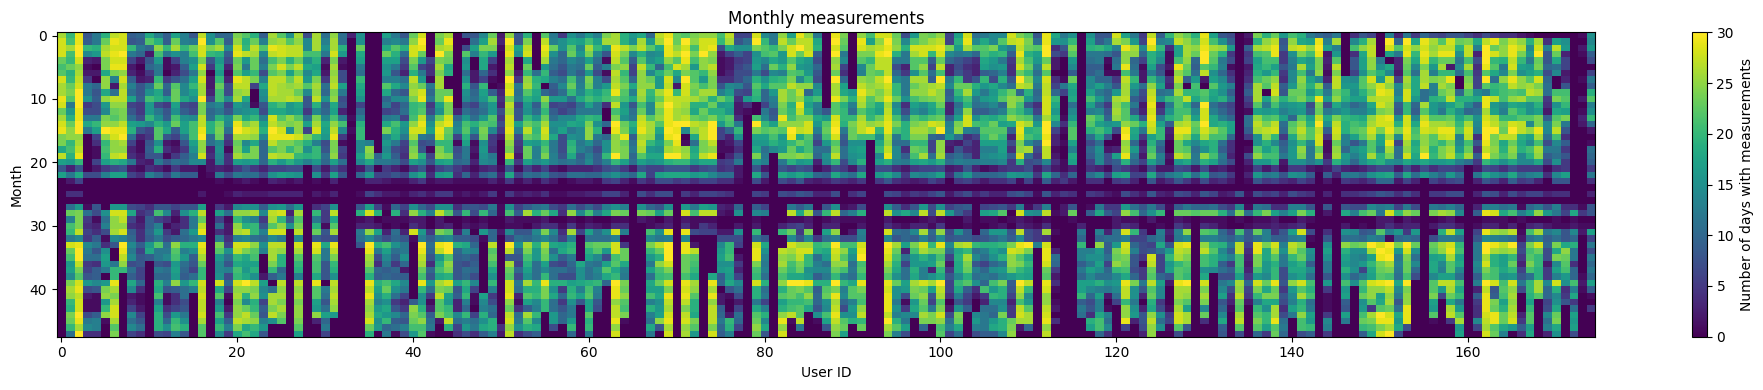

In [10]:
plt.figure(figsize=(20, 4))

plt.imshow(
    X_monthly_indicator.T,
    cmap="viridis",
    interpolation="nearest",
    aspect="auto",
    vmin=0,
    vmax=30,
)
plt.colorbar(label="Number of days with measurements")
plt.title("Monthly measurements")
plt.xlabel("User ID")
plt.ylabel("Month")
# plt.xticks(np.arange(num_users), user_ids, rotation=90)
# plt.yticks(np.arange(0, num_days//30), np.arange(2, num_days//30+1))
plt.tight_layout()

In [11]:
data_availability = ~np.isnan(X_tensor.sum(axis=-1))
data_availability_user = data_availability.sum(axis=-1) / num_days * 100
data_availability_day = data_availability.sum(axis=0) / num_users * 100
print(f"Data availability: {data_availability.sum()}/{num_days*num_users} = {data_availability.mean()*100:.2f}%")

Data availability: 107559/255675 = 42.07%


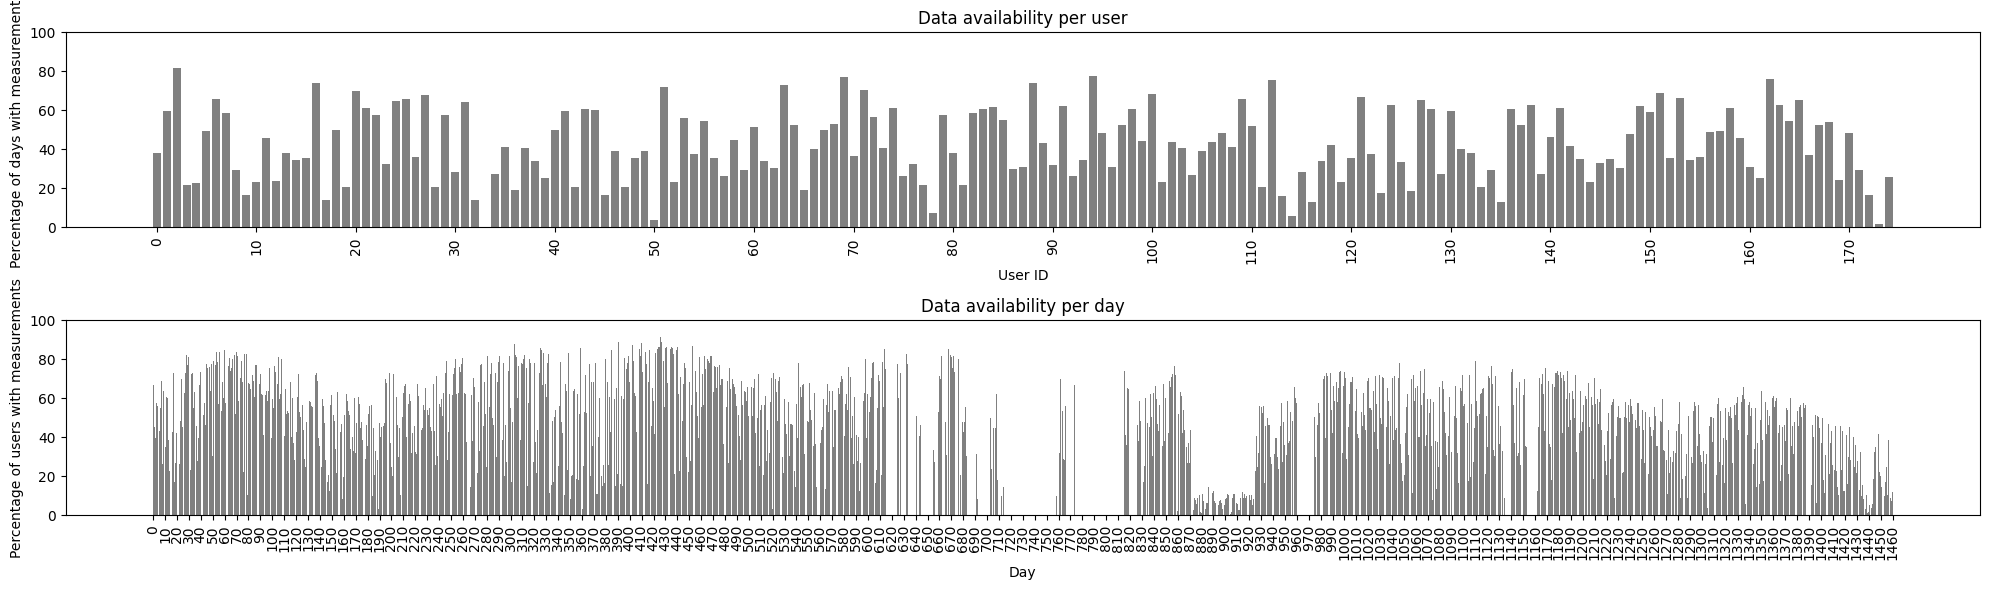

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(20, 6))
ax[0].bar(np.arange(num_users), data_availability_user, color="grey")
ax[0].set_title("Data availability per user")
ax[0].set_xlabel("User ID")
ax[0].set_ylabel("Percentage of days with measurements")
ax[0].set_ylim(0, 100)
ax[0].set_xticks(np.arange(0, num_users, 10))
ax[0].set_xticklabels(np.arange(0, num_users, 10), rotation=90)
ax[1].bar(np.arange(num_days), data_availability_day, color="grey")
ax[1].set_title("Data availability per day")
ax[1].set_xlabel("Day")
ax[1].set_ylabel("Percentage of users with measurements")
ax[1].set_ylim(0, 100)
ax[1].set_xticks(np.arange(0, num_days, 10))
ax[1].set_xticklabels(np.arange(0, num_days, 10), rotation=90)
plt.tight_layout()
plt.show()

In [13]:
X_user_scaled = (X_user)/metadata["estimated_ac_capacity"].values[:,None]*1000
# max_values = np.nanmax(X_user, axis=1)[...,None]
# X_user_scaled = (X_user)/max_values
# nonzero_mean, nonzero_std = zero_preserved_log_stats(X_user_scaled.flatten()[...,None])
# X_nrm = zero_preserved_log_normalize(X_user_scaled, nonzero_mean, nonzero_std, log_output=True, zero_id=-3, shift=1.0).reshape(num_users, -1)
X_nrm = np.reshape(X_user_scaled, (num_users, -1, X.shape[-1]))

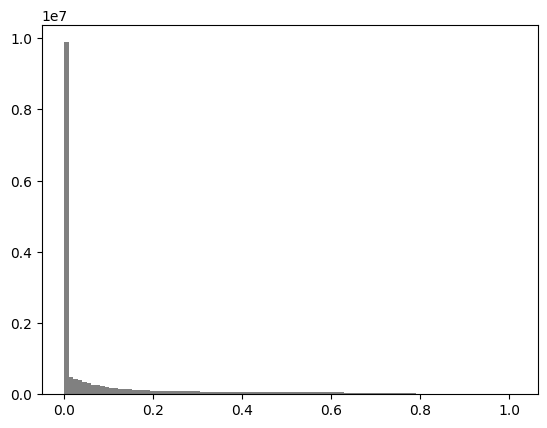

In [14]:
plt.hist(X_nrm.flatten(), bins=100, color="grey")
plt.show()

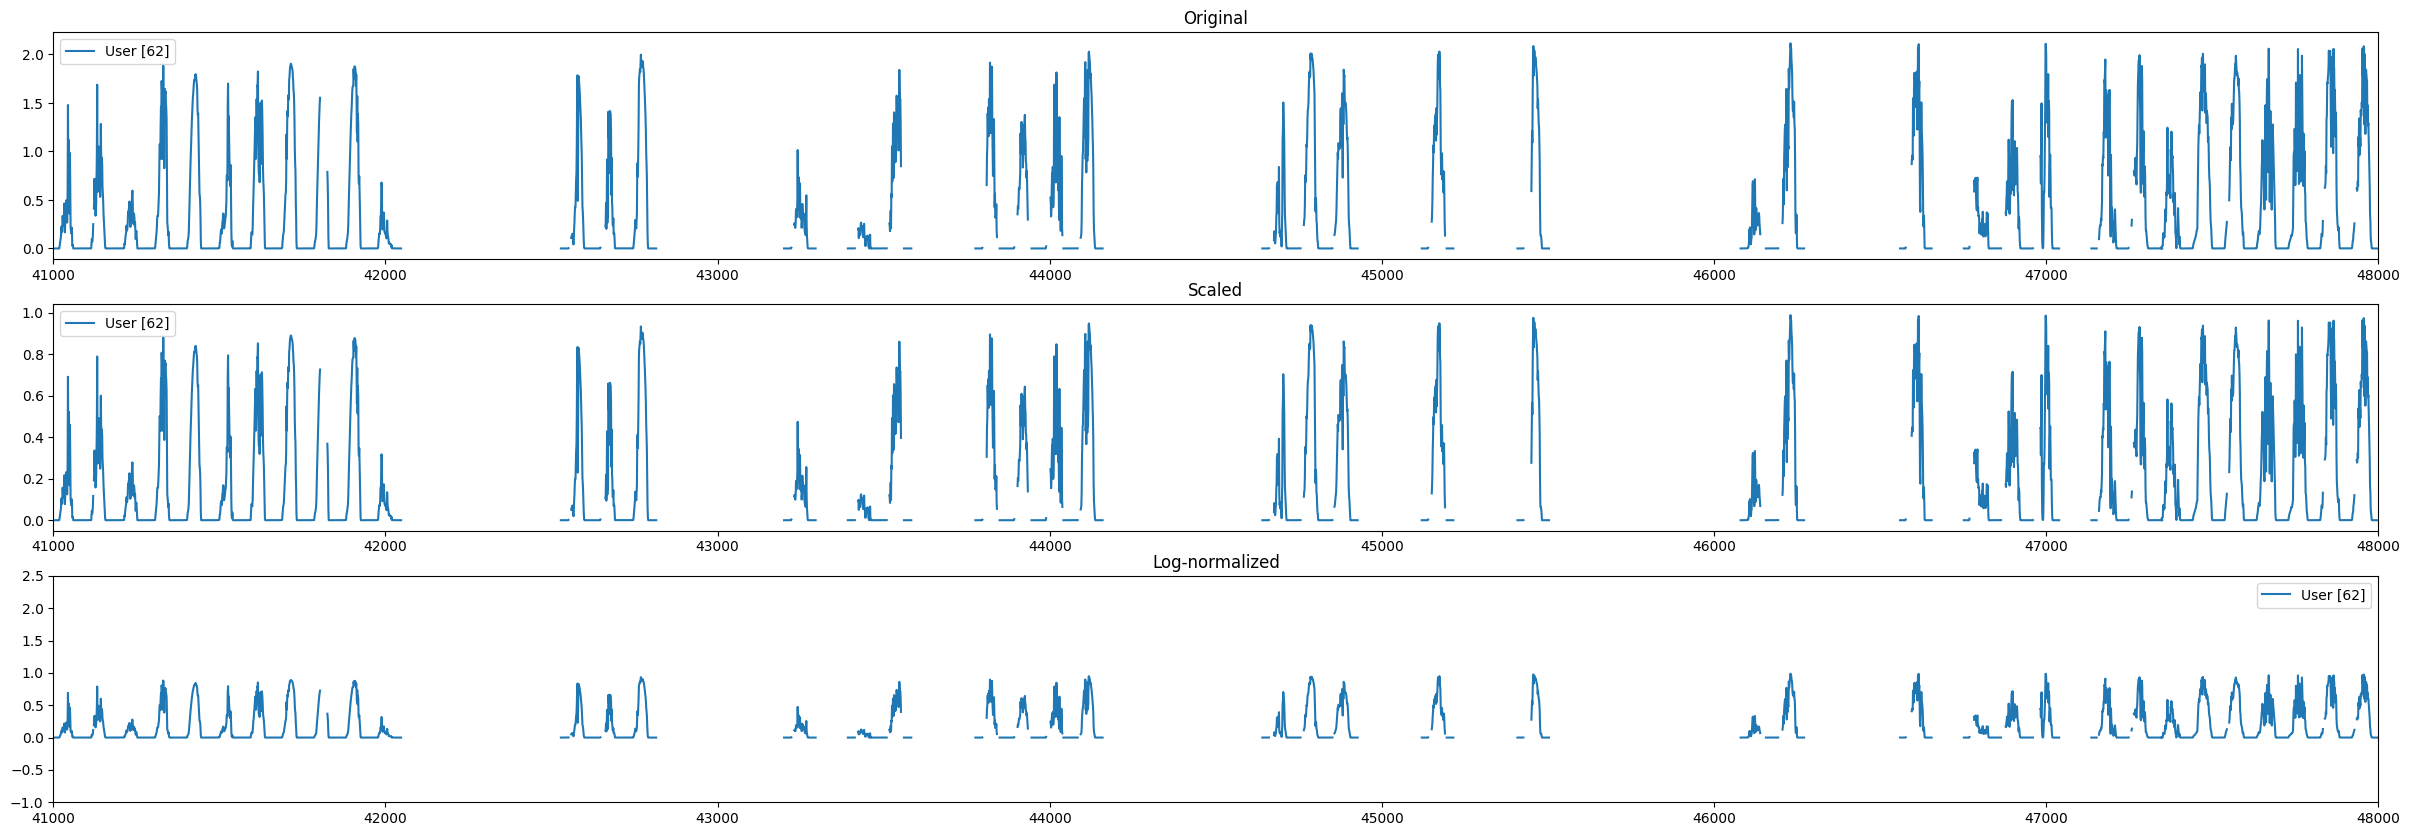

In [15]:
user_idx = [62]

fig, ax = plt.subplots(3, 1, figsize=(30,10))

ax[0].plot(X_user[user_idx].T, label=f"User {user_idx}")
ax[1].plot(X_user_scaled[user_idx].T, label=f"User {user_idx}")
ax[2].plot(X_nrm[user_idx].flatten().T, label=f"User {user_idx}")

ax[0].set_title("Original")
ax[1].set_title("Scaled")
ax[2].set_title("Log-normalized")

for ax_ in ax:
    ax_.legend(ncol=10)
    ax_.set_xlim(41000, 48000)

ax[-1].set_ylim(-1, 2.5)

plt.legend()

plt.show()


In [16]:
NUM_TEST_DAYS = 0
train_days_idx = np.arange(0, num_days-NUM_TEST_DAYS)
test_days_idx = np.arange(num_days-NUM_TEST_DAYS, num_days)
X_train = X_nrm[:,train_days_idx]
X_test = X_nrm[:,test_days_idx]

# X_proxy = X_train[:, X_train.shape[1]%X_test.shape[1]:].reshape(num_users, X_train.shape[1]//X_test.shape[1], NUM_TEST_DAYS, X_test.shape[-1])


In [17]:
user_model = UserEncoder(num_topics=6, num_clusters=1000, random_state=2112, reduce_dim=True, num_lower_dims=96)

In [18]:
user_model.fit(X_train,
        fit_kwargs={"lda": {
                    "perp_tol": 0.1,
                    "max_iter": 1000,
                    "batch_size": 64,
                    "verbose": True,
                    "learning_method": "online",
                    "evaluate_every": 5,
                    "n_jobs": None,
                    "doc_topic_prior": 1/user_model.num_topics,
                    "topic_word_prior": 1/user_model.num_clusters,
                }})

iteration: 1 of max_iter: 1000
iteration: 2 of max_iter: 1000
iteration: 3 of max_iter: 1000
iteration: 4 of max_iter: 1000
iteration: 5 of max_iter: 1000, perplexity: 847.6465
iteration: 6 of max_iter: 1000
iteration: 7 of max_iter: 1000
iteration: 8 of max_iter: 1000
iteration: 9 of max_iter: 1000
iteration: 10 of max_iter: 1000, perplexity: 818.3648
iteration: 11 of max_iter: 1000
iteration: 12 of max_iter: 1000
iteration: 13 of max_iter: 1000
iteration: 14 of max_iter: 1000
iteration: 15 of max_iter: 1000, perplexity: 800.0489
iteration: 16 of max_iter: 1000
iteration: 17 of max_iter: 1000
iteration: 18 of max_iter: 1000
iteration: 19 of max_iter: 1000
iteration: 20 of max_iter: 1000, perplexity: 786.4486
iteration: 21 of max_iter: 1000
iteration: 22 of max_iter: 1000
iteration: 23 of max_iter: 1000
iteration: 24 of max_iter: 1000
iteration: 25 of max_iter: 1000, perplexity: 776.1216
iteration: 26 of max_iter: 1000
iteration: 27 of max_iter: 1000
iteration: 28 of max_iter: 1000
ite

UserEncoder(num_clusters=1000, num_lower_dims=96, num_topics=6,
            random_state=2112, reduce_dim=True)

In [19]:
gamma_matrix = user_model.transform(X_train)
beta_matrix = user_model.lambda_matrix/np.sum(user_model.lambda_matrix, axis=1, keepdims=True)

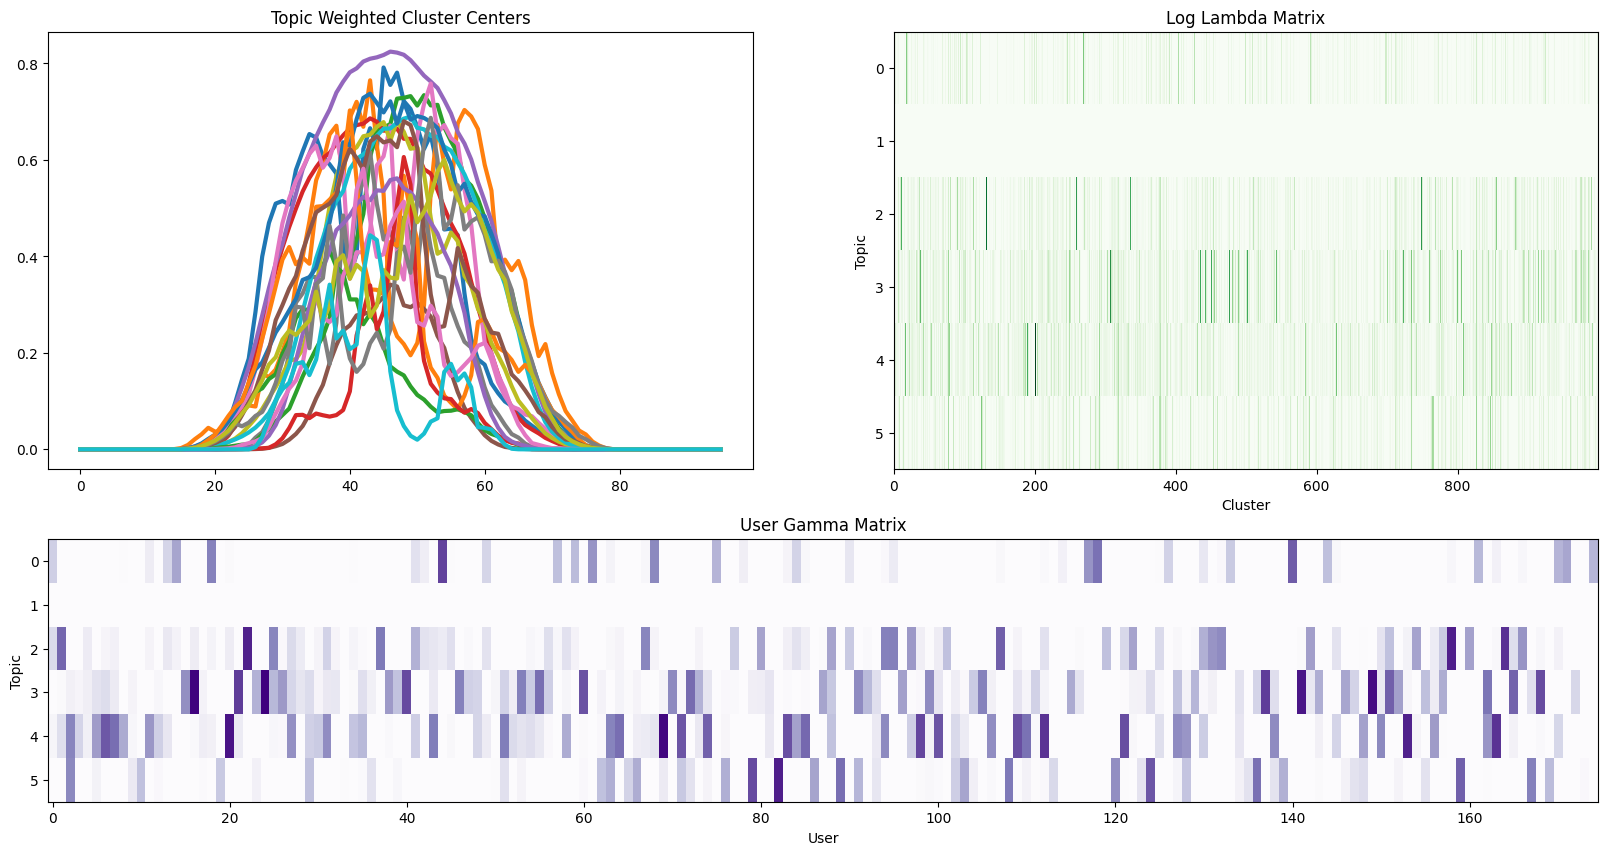

In [20]:
fig = plt.figure(figsize=(20, 10))
gs = mpl.gridspec.GridSpec(2, 2, height_ratios=[5, 3])
ax_top_left = fig.add_subplot(gs[0, 0])
ax_top_right = fig.add_subplot(gs[0, 1])
ax_bottom = fig.add_subplot(gs[1, :])
ax = [ax_top_left, ax_top_right]  # used by the existing code below
ax[0].plot((user_model.cluster_centers@user_model.reducer_matrix)[::50].T, alpha=1.0, lw=3)
ax[0].set_title('Topic Weighted Cluster Centers')
ax[1].imshow((user_model.lambda_matrix), cmap='Greens', aspect='auto', interpolation='nearest')
ax[1].set_xlabel('Cluster')
ax[1].set_ylabel('Topic')
ax[1].set_title('Log Lambda Matrix')
ax[1].set_yticks(np.arange(user_model.lambda_matrix.shape[0]))
ax_bottom.imshow(gamma_matrix.T, cmap='Purples', aspect='auto', interpolation='nearest')
ax_bottom.set_xlabel('User')
ax_bottom.set_ylabel('Topic')
ax_bottom.set_title('User Gamma Matrix')
plt.grid(False)
plt.show()

In [21]:
distance_measure = bhattacharyya_distance_dirichlet
distances = distance_measure(gamma_matrix[:,:,None], gamma_matrix.T[None,:,:])

In [22]:
NUM_CLUSTERS = 8

clustering = AgglomerativeClustering(n_clusters=NUM_CLUSTERS, metric="precomputed", linkage="complete", compute_distances=True, distance_threshold=None).fit(distances)
labels = clustering.labels_

In [23]:
#number of unique labels in labels in terms of occurance
unique_labels, counts = np.unique(labels, return_counts=True)
print(f"Number of unique labels: {len(unique_labels)}")
print(f"Counts of unique labels: {counts}")

Number of unique labels: 8
Counts of unique labels: [43 27 24 25 14 23  7 12]


In [24]:
user_count_threshold = 1
labels_filtered = labels.copy()

for i in np.unique(labels):
    if np.sum(labels==i) <= user_count_threshold: labels_filtered[labels==i] = -1

unique_labels = np.unique(labels_filtered[labels_filtered != -1])
num_stereotypes_filtered = np.unique(labels_filtered[labels_filtered != -1]).shape[0]

print(f"Number of filtered stereotypes: {num_stereotypes_filtered}")

Number of filtered stereotypes: 8


In [25]:
X_flt = X_user_scaled.reshape(num_users, -1)
window_size = np.min([X_flt.shape[1], 24*60//15//RESOLUTION*7])
shift = -24*60//15//RESOLUTION*250
X_flt = X_flt[:, shift+(X_flt.shape[1]-window_size)//2:shift+(X_flt.shape[1]+window_size)//2]

In [26]:
quantiles = [0.05, 0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 0.9, 0.95]

In [27]:
quantile_levels = np.zeros((NUM_CLUSTERS, len(quantiles), X_flt.shape[-1]))
for i in range(NUM_CLUSTERS):
    quantile_levels[i] = fnq.nanquantile(X_flt[labels_filtered==i], quantiles, axis=0)

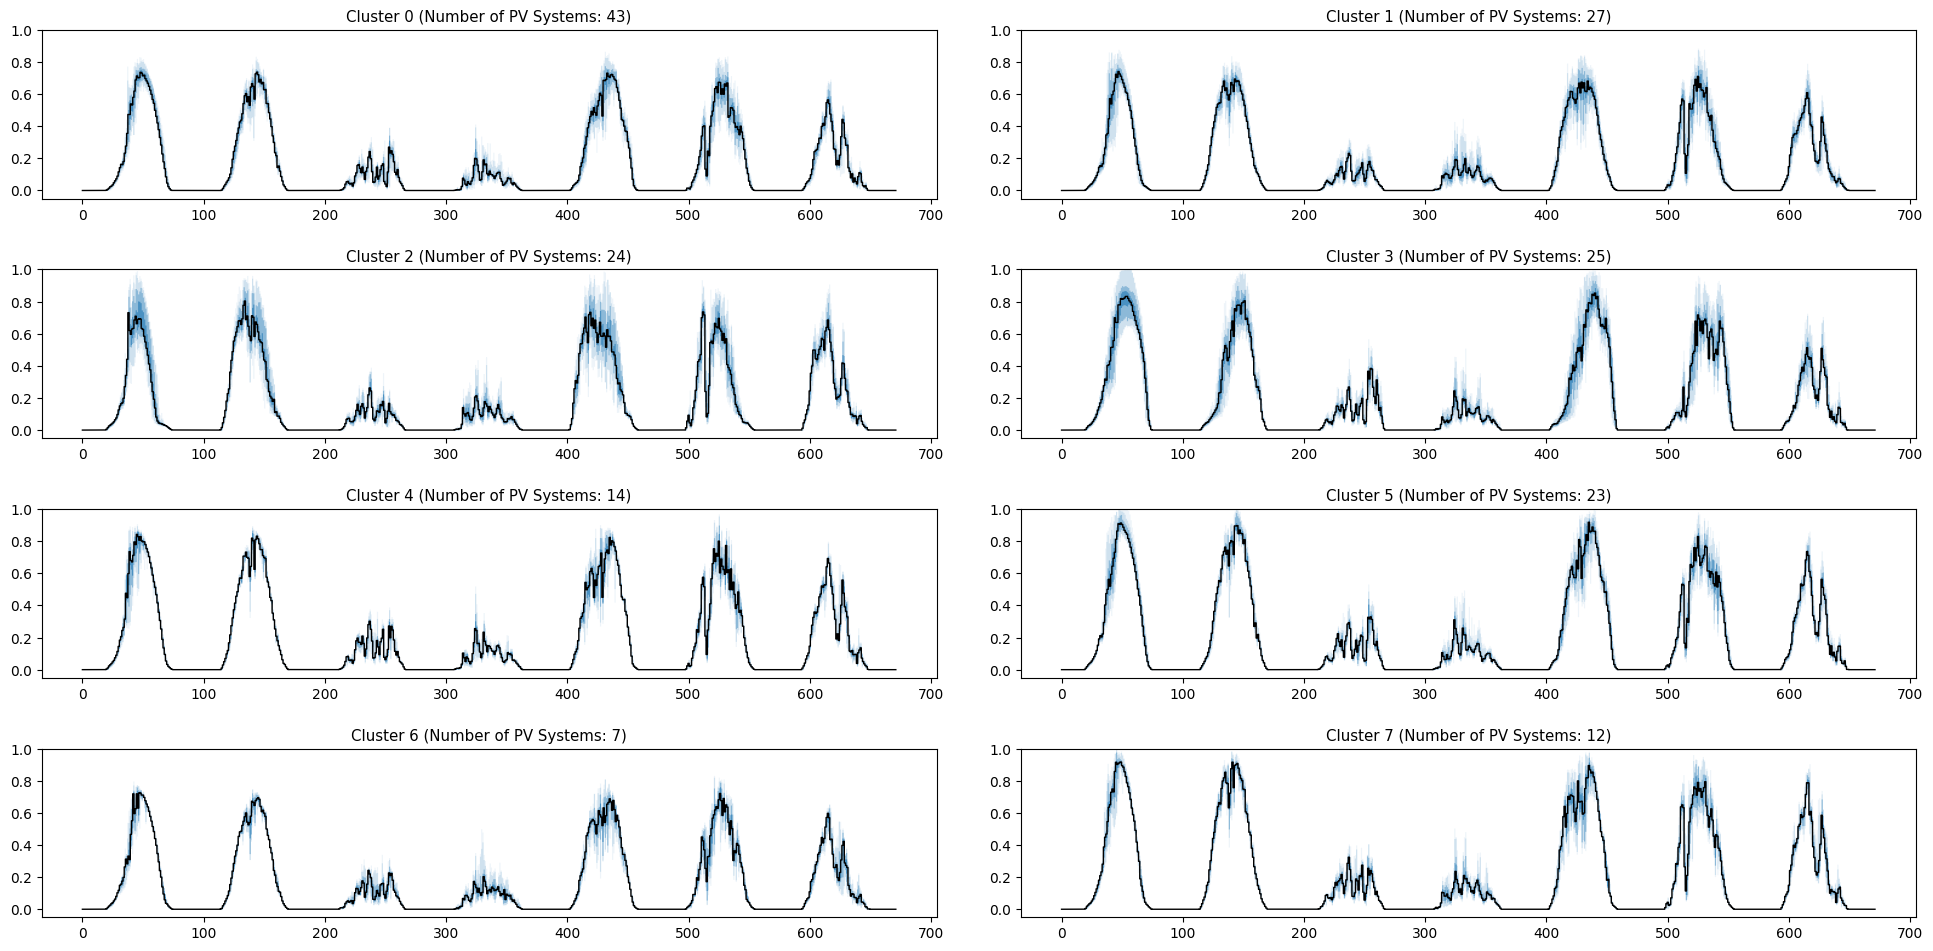

In [28]:
fig, ax = plt.subplots(num_stereotypes_filtered//2 + num_stereotypes_filtered%2, 2, figsize=(20, 10))
fig.tight_layout(pad=3.0)
plt.rcParams.update({'font.size':9})

for i, stereotype_no in enumerate(unique_labels):
    for j in range(len(quantiles)//2): ax[i//2, i%2].fill_between(np.arange(X_flt.shape[1]), quantile_levels[i,j], quantile_levels[i,-j-1], alpha=(1.5*quantiles[j])**(1/1.0), color="tab:blue", lw=0, step="mid")
    ax[i//2, i%2].step(np.arange(X_flt.shape[1]), quantile_levels[i, np.where(np.array(quantiles)==0.5)[0][0]], alpha=1.0, color="k", lw=1.0, where="mid")
    ax[i//2, i%2].set_title(f"Cluster {stereotype_no} (Number of PV Systems: {np.sum(labels_filtered==stereotype_no)})" )
    ax[i//2, i%2].set_ylim(-0.05, 1)

In [29]:
quantile_levels_entity = np.zeros((len(quantiles), num_users, *X_train.shape[-2:]))
for u in range(num_users): 
    cluster_members = np.where(labels_filtered==labels_filtered[u])[0]
    cluster_members = cluster_members[cluster_members != u]
    quantile_levels_entity[:,u] = fnq.nanquantile(X_train[cluster_members], quantiles, axis=0)

In [30]:
results = {"entity":{}}

In [31]:
_, quantile_losses = calculate_quantile_loss(targets=X_train, quantile_predictions=quantile_levels_entity, quantiles=quantiles, nonzero=False)

/home/kbolat/Python/entity-clustering/utils.py:76: RuntimeWarning: Mean of empty slice
  quantiles_losses = np.nanmean(quantiles_losses, axis=-1)


In [32]:
score, scores, iqrs = calculate_interval_score(targets=X_train, quantile_predictions=quantile_levels_entity, quantiles=quantiles, weighted=True)

/home/kbolat/Python/entity-clustering/utils.py:108: RuntimeWarning: Mean of empty slice
  scores = np.nanmean(scores, axis=0)


In [38]:
results["entity"]["quantile_loss"] = {}
for i, q in enumerate(quantiles): 
    results["entity"]["quantile_loss"][q] = {}
    for u in range(num_users):
        results["entity"]["quantile_loss"][q][u] = np.nanmean(quantile_losses[i, u])
results["entity"]["quantile_loss"]["mean"] = np.nanmean(quantile_losses)

## No clustering

In [39]:
quantile_levels_pooled = fnq.nanquantile(X_flt, quantiles, axis=0)

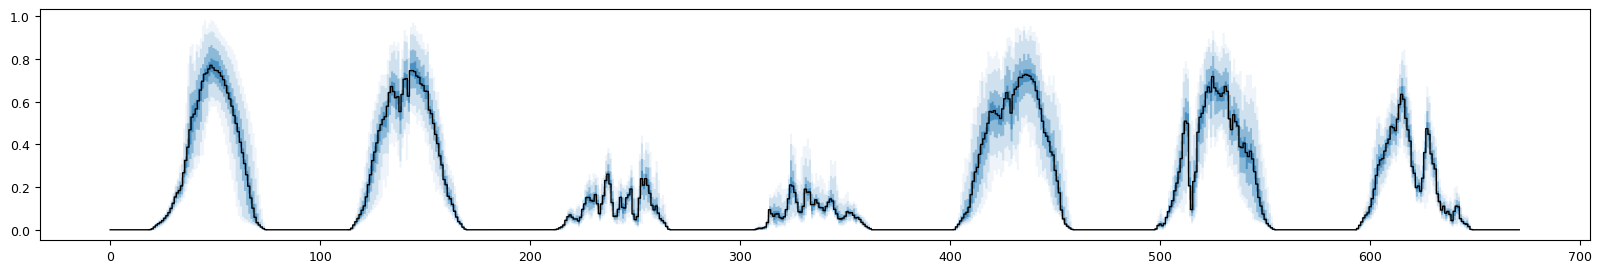

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(20, 3))

for j in range(len(quantiles)//2): ax.fill_between(np.arange(X_flt.shape[1]), quantile_levels_pooled[j], quantile_levels_pooled[-j-1], alpha=(1.5*quantiles[j])**(1/1.0), color="tab:blue", lw=0, step="mid")
ax.step(np.arange(X_flt.shape[1]), quantile_levels_pooled[np.where(np.array(quantiles)==0.5)[0][0]], alpha=1.0, color="k", lw=1.0, where="mid")
plt.show()

In [41]:
quantile_levels_pooled = np.zeros((len(quantiles), num_users, *X_train.shape[-2:]))
for u in range(num_users): 
    cluster_members = np.arange(num_users)
    cluster_members = cluster_members[cluster_members != u]
    quantile_levels_pooled[:,u] = fnq.nanquantile(X_train[cluster_members], quantiles, axis=0)

KeyboardInterrupt: 

In [ ]:
results["pooled"] = {}

In [ ]:
_, quantile_losses = calculate_quantile_loss(targets=X_train, quantile_predictions=quantile_levels_pooled, quantiles=quantiles, nonzero=True)

In [ ]:
results["pooled"]["quantile_loss"] = {}
for i, q in enumerate(quantiles): 
    results["pooled"]["quantile_loss"][q] = {}
    for u in range(num_users): results["pooled"]["quantile_loss"][q][u] = np.nanmean(quantile_losses[i, u])
results["pooled"]["quantile_loss"]["mean"] = np.nanmean(quantile_losses)

## Physics Clustering

In [ ]:
phy_features = metadata[["tilt", "azimuth"]].values

In [ ]:
kmeans_phy = KMeans(n_clusters=NUM_CLUSTERS, random_state=55).fit(phy_features)
labels_phy = kmeans_phy.labels_

In [ ]:
quantile_levels_phy = np.zeros((NUM_CLUSTERS, len(quantiles), X_flt.shape[-1]))
for i in range(NUM_CLUSTERS):
    quantile_levels_phy[i] = fnq.nanquantile(X_flt[labels_phy==i], quantiles, axis=0)

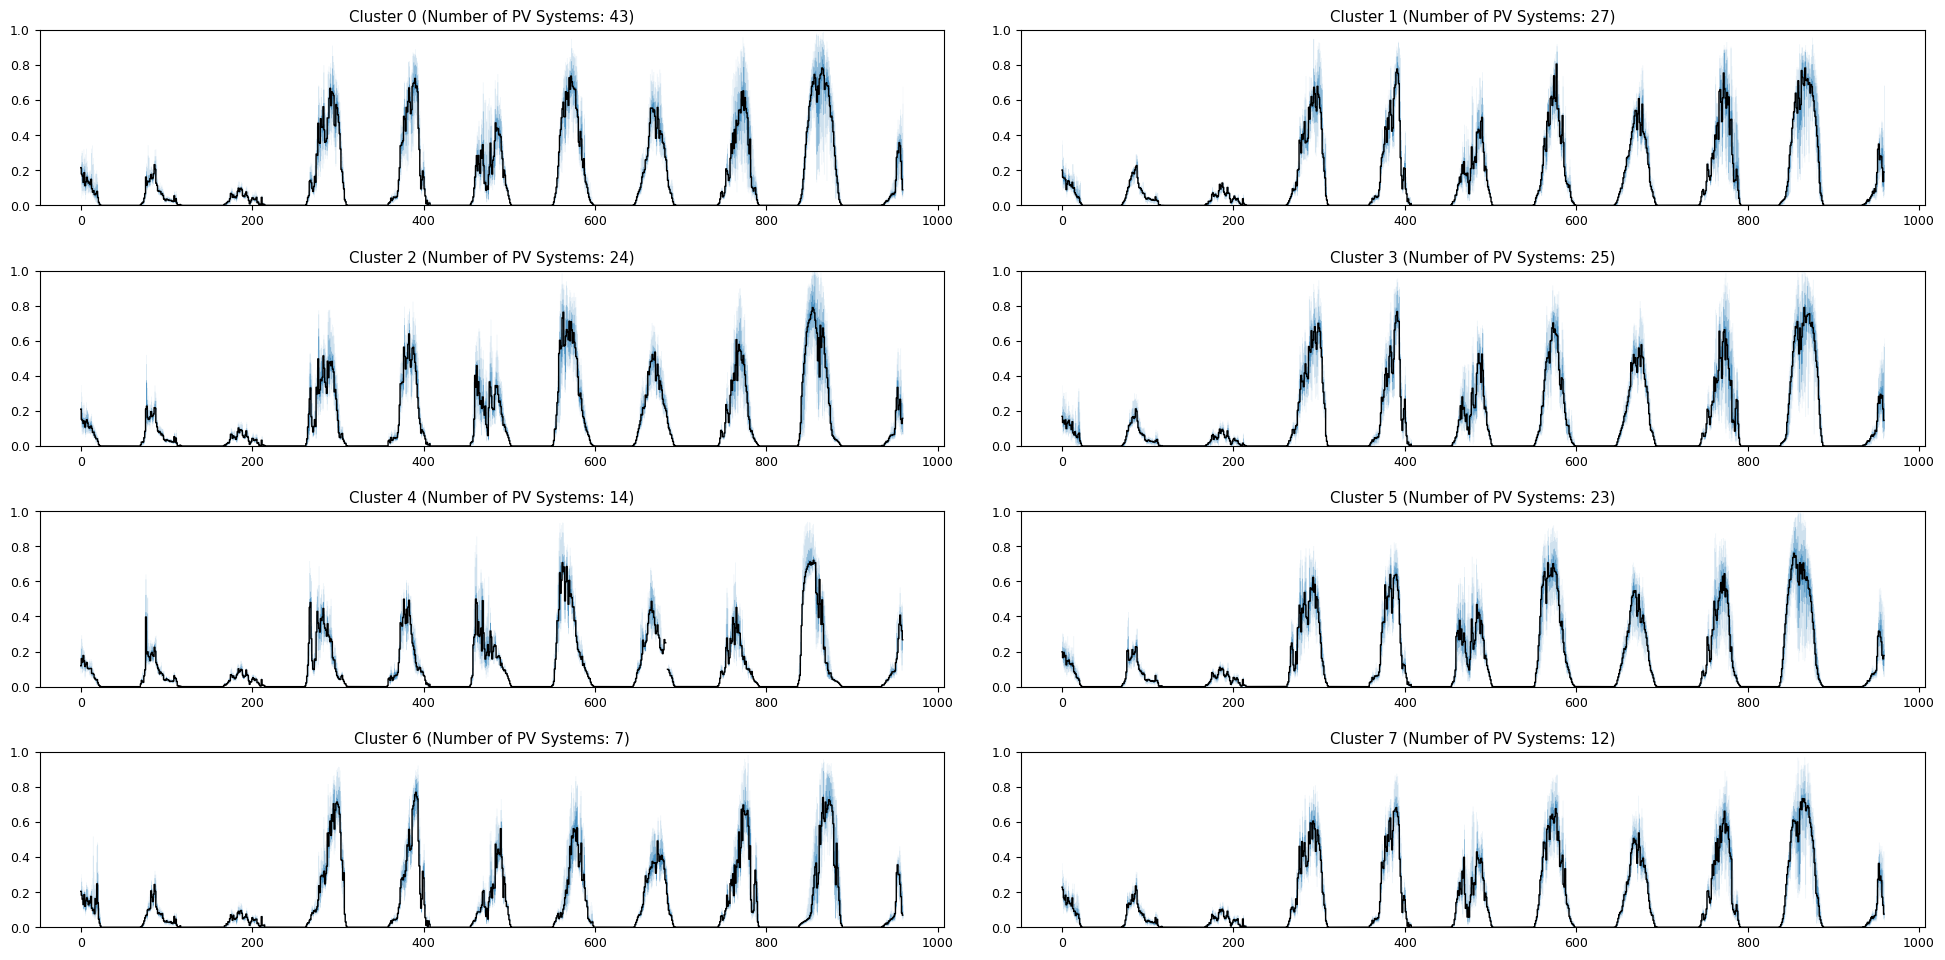

In [ ]:
fig, ax = plt.subplots(num_stereotypes_filtered//2 + num_stereotypes_filtered%2, 2, figsize=(20, 10))
fig.tight_layout(pad=3.0)
plt.rcParams.update({'font.size':9})

for i, stereotype_no in enumerate(unique_labels):
    for j in range(len(quantiles)//2): ax[i//2, i%2].fill_between(np.arange(X_flt.shape[1]), quantile_levels_phy[i,j], quantile_levels_phy[i,-j-1], alpha=(1.5*quantiles[j])**(1/1.0), color="tab:blue", lw=0, step="mid")
    ax[i//2, i%2].step(np.arange(X_flt.shape[1]), quantile_levels_phy[i, np.where(np.array(quantiles)==0.5)[0][0]], alpha=1.0, color="k", lw=1.0, where="mid")
    ax[i//2, i%2].set_title(f"Cluster {stereotype_no} (Number of PV Systems: {np.sum(labels_filtered==stereotype_no)})" )
    ax[i//2, i%2].set_ylim(0, 1)

In [ ]:
quantile_levels_phy = np.zeros((len(quantiles), num_users, *X_train.shape[-2:]))
for u in range(num_users): 
    cluster_members = np.where(labels_phy==labels_phy[u])[0]
    cluster_members = cluster_members[cluster_members != u]
    quantile_levels_phy[:,u] = fnq.nanquantile(X_train[cluster_members], quantiles, axis=0)

In [ ]:
results["phy"] = {}

In [ ]:
_, quantile_losses = calculate_quantile_loss(targets=X_train, quantile_predictions=quantile_levels_phy, quantiles=quantiles, nonzero=True)

In [ ]:
results["phy"]["quantile_loss"] = {}
for i, q in enumerate(quantiles): 
    results["phy"]["quantile_loss"][q] = {}
    for u in range(num_users): results["phy"]["quantile_loss"][q][u] = np.nanmean(quantile_losses[i, u])
results["phy"]["quantile_loss"]["mean"] = np.nanmean(quantile_losses)

## Missing value visualization

In [42]:
X_flt_ = X_user_scaled.reshape(num_users, -1)
window_size = np.min([X_flt_.shape[-1], 24*4*15])
shift = -24*4*576
start = (shift+X_flt_.shape[-1]//2)-(window_size)//2
end = (shift+X_flt_.shape[-1]//2)+(window_size)//2
X_flt = X_flt_[:, start:end]

In [43]:
quantile_levels = np.zeros((NUM_CLUSTERS, len(quantiles), X_flt.shape[-1]))
for i in range(NUM_CLUSTERS):
    quantile_levels[i] = fnq.nanquantile(X_flt[labels_filtered==i], quantiles, axis=0)

In [44]:
quantile_levels_phy = np.zeros((NUM_CLUSTERS, len(quantiles), X_flt.shape[-1]))
for i in range(NUM_CLUSTERS):
    quantile_levels_phy[i] = fnq.nanquantile(X_flt[labels_phy==i], quantiles, axis=0)

NameError: name 'labels_phy' is not defined

In [45]:
quantile_levels_pooled = np.zeros((len(quantiles), *X_train.shape[-2:]))
quantile_levels_pooled = fnq.nanquantile(X_flt, quantiles, axis=0)

In [46]:
np.where(labels_filtered==7)

(array([  8,  11,  20,  34,  64,  83,  85,  98, 112, 121, 153, 163]),)

In [47]:
sns.set_context("paper", font_scale=2.5)
sns.set_style("whitegrid")

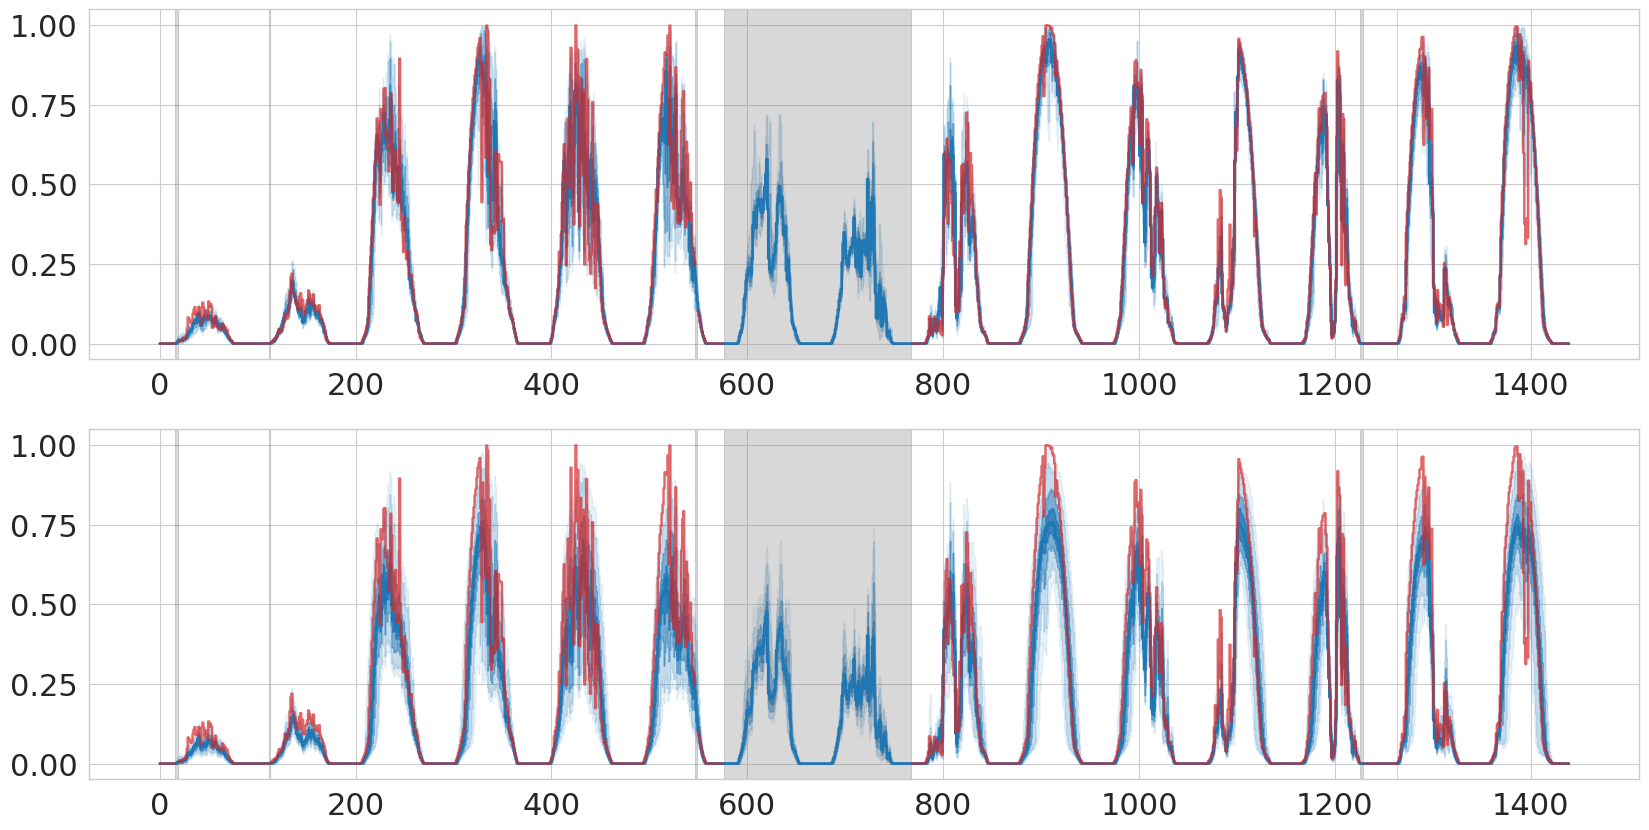

In [48]:
import itertools

user_idx = 163
fig, ax = plt.subplots(2, 1, figsize=(20,10))
for j in range(len(quantiles)//2): ax[0].fill_between(np.arange(X_flt.shape[1]), quantile_levels[labels[user_idx],j], quantile_levels[labels[user_idx], -j-1], alpha=(1.5*quantiles[j])**(1/1.0), color="tab:blue", lw=1.0, step="mid")
ax[0].step(np.arange(X_flt.shape[1]), quantile_levels[labels[user_idx], np.where(np.array(quantiles)==0.5)[0][0]], alpha=1.0, lw=2.0, where="mid")
ax[0].step(np.arange(X_flt.shape[1]), X_flt[user_idx].T, alpha=0.7, lw=1.75, where="mid", color="C3")

# for j in range(len(quantiles)//2): ax[1].fill_between(np.arange(X_flt.shape[1]), quantile_levels_phy[labels_phy[user_idx],j], quantile_levels_phy[labels_phy[user_idx], -j-1], alpha=(1.5*quantiles[j])**(1/1.0), color="tab:blue", lw=1.00, step="mid")
# ax[1].step(np.arange(X_flt.shape[1]), quantile_levels_phy[labels_phy[user_idx], np.where(np.array(quantiles)==0.5)[0][0]], alpha=1.0, lw=2.0, where="mid")
# ax[1].step(np.arange(X_flt.shape[1]), X_flt[user_idx].T, alpha=0.7, lw=1.75, where="mid", color="C3")

for j in range(len(quantiles)//2): ax[1].fill_between(np.arange(X_flt.shape[1]), quantile_levels_pooled[j], quantile_levels_pooled[-j-1], alpha=(1.8*quantiles[j])**(1/1.0), color="tab:blue", lw=1.0, step="mid")
ax[1].step(np.arange(X_flt.shape[1]), quantile_levels_pooled[np.where(np.array(quantiles)==0.5)[0][0]], alpha=1.0, lw=2.0, where="mid")
ax[1].step(np.arange(X_flt.shape[1]), X_flt[user_idx].T, alpha=0.7, lw=1.75, where="mid", color="C3")

for _, group in itertools.groupby(enumerate(np.where(np.isnan(X_flt[user_idx]))[0]), key=lambda x: x[1] - x[0]):
    indices = [x for _, x in group]
    start_, end_ = indices[0], indices[-1]
    for a in ax: a.axvspan(start_, end_, color="grey", alpha=0.3)


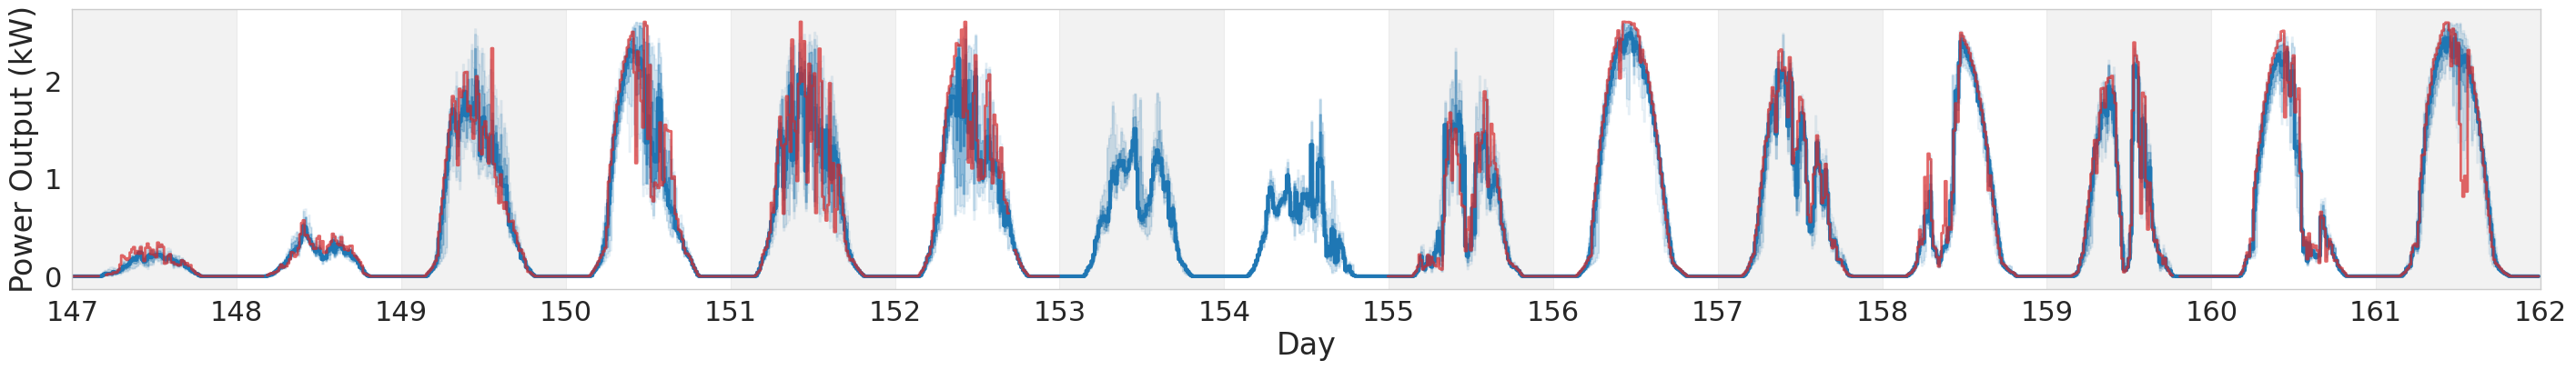

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(35,4))
scl = metadata["estimated_ac_capacity"].values[user_idx]/1000
for j in range(len(quantiles)//2): ax.fill_between(np.arange(X_flt.shape[1]), scl*quantile_levels[labels[user_idx],j], scl*quantile_levels[labels[user_idx], -j-1], alpha=(1.5*quantiles[j])**(1/1.0), color="tab:blue", lw=1.0, step="mid")
ax.step(np.arange(X_flt.shape[1]), scl*quantile_levels[labels[user_idx], np.where(np.array(quantiles)==0.5)[0][0]], alpha=1.0, lw=3.0, where="mid")
ax.step(np.arange(X_flt.shape[1]), scl*X_flt[user_idx].T, alpha=0.7, lw=2, where="mid", color="C3")

interval = 24 * 4  # 96 time steps
for start_ in range(0, X_flt.shape[1], 2 * interval):
    ax.axvspan(start_, start_ + interval, color='grey', alpha=0.1)
day_length = 96  # assuming each day has 96 timesteps
days = np.arange(0, X_flt.shape[1] // day_length + 1)
tick_positions = days * day_length
ax.set_xticks(tick_positions)
ax.set_xticklabels(start//96+days)
ax.set_xlabel("Day")
ax.set_xlim(0, X_flt.shape[1])
ax.grid(False)
ax.set_ylabel("Power Output (kW)")
plt.savefig("results/quantile_representation.png", dpi=300, bbox_inches='tight')
plt.show()

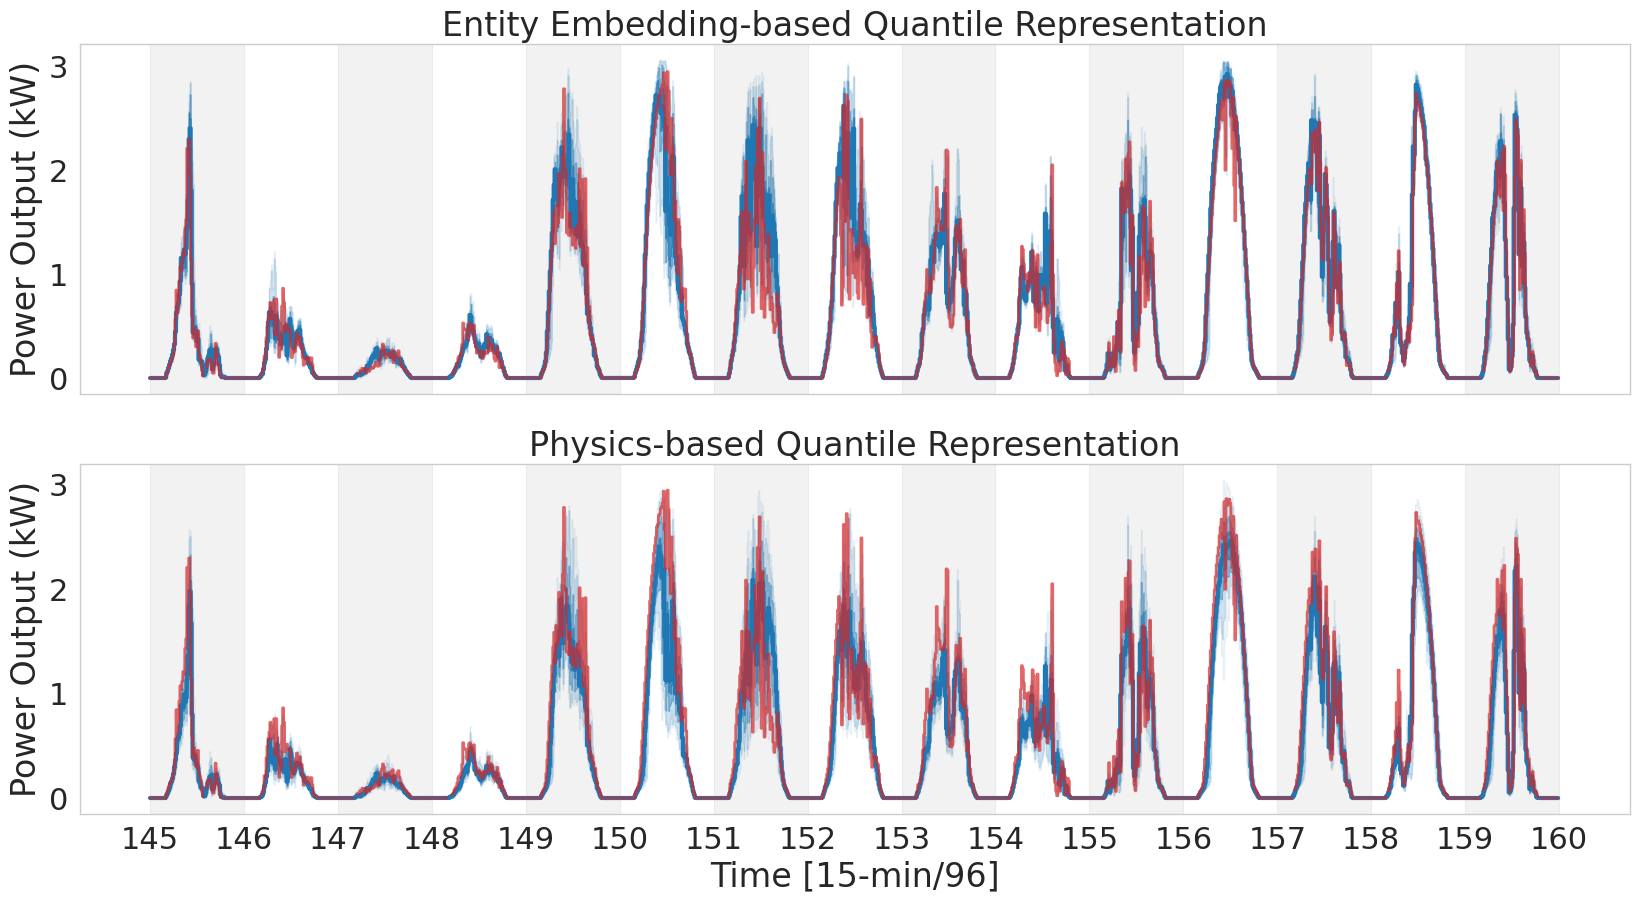

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
scl = metadata["estimated_ac_capacity"].values[user_idx]/1000
for j in range(len(quantiles)//2): ax[0].fill_between(np.arange(X_flt.shape[1]), scl*quantile_levels[labels[user_idx],j], scl*quantile_levels[labels[user_idx], -j-1], alpha=(1.5*quantiles[j])**(1/1.0), color="tab:blue", lw=1.0, step="mid")
ax[0].step(np.arange(X_flt.shape[1]), scl*quantile_levels[labels[user_idx], np.where(np.array(quantiles)==0.5)[0][0]], alpha=1.0, lw=3.0, where="mid")
ax[0].step(np.arange(X_flt.shape[1]), scl*X_flt[user_idx].T, alpha=0.7, lw=2, where="mid", color="C3")

for j in range(len(quantiles)//2): ax[1].fill_between(np.arange(X_flt.shape[1]), scl*quantile_levels_phy[labels_phy[user_idx],j], scl*quantile_levels_phy[labels_phy[user_idx], -j-1], alpha=(1.5*quantiles[j])**(1/1.0), color="tab:blue", lw=1.00, step="mid")
ax[1].step(np.arange(X_flt.shape[1]), scl*quantile_levels_phy[labels_phy[user_idx], np.where(np.array(quantiles)==0.5)[0][0]], alpha=1.0, lw=3.0, where="mid")
ax[1].step(np.arange(X_flt.shape[1]), scl*X_flt[user_idx].T, alpha=0.7, lw=2, where="mid", color="C3")

interval = 24 * 4  # 96 time steps
for start_ in range(0, X_flt.shape[1], 2 * interval):
    for a in ax:
        a.axvspan(start_, start_ + interval, color='grey', alpha=0.1)
day_length = 96  # assuming each day has 96 timesteps
days = np.arange(0, X_flt.shape[1] // day_length + 1)
tick_positions = days * day_length
ax[-1].set_xticks(tick_positions)
ax[-1].set_xticklabels(start//96+days)
ax[-1].set_xlabel("Time [15-min/96]")

ax[0].set_title("Entity Embedding-based Quantile Representation")
ax[1].set_title("Physics-based Quantile Representation")
##grid off
for ax_ in ax:
    ax_.grid(False)
    ax_.set_ylabel("Power Output (kW)")

# fig.tight_layout()
plt.savefig("results/quantile_representation.png", dpi=300, bbox_inches='tight')
plt.show()

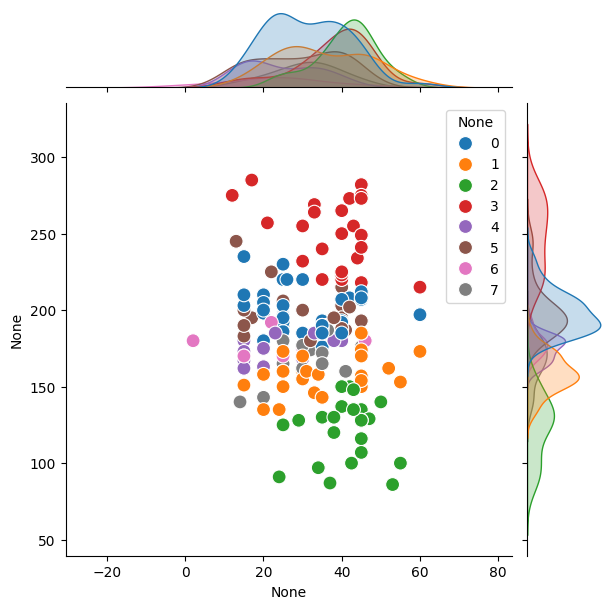

In [ ]:
# plt.scatter(phy_features[:,0], phy_features[:,1], c=labels_filtered, cmap="tab10", s=5)
# sns.displot(x=phy_features[:,0], y=phy_features[:,1], hue=labels_filtered, palette="tab10", height=5, aspect=2, kind="kde", fill=False, alpha=0.5)
# sns.scatterplot(x=phy_features[:,0], y=phy_features[:,1], hue=labels_filtered, palette="tab10", s=100)
sns.jointplot(x=phy_features[:,0], y=phy_features[:,1], hue=labels_filtered, palette="tab10", s=100)